In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Initial Data Preparation

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [3]:
df = pd.read_csv("../03-Classification/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(" " , "_")

In [6]:
tc = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

In [7]:
df.churn = (df.churn == "yes").astype(int)

## Setting up validation framework

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)
len(df_train) , len(df_val) , len(df_test)

(4225, 1409, 1409)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

## EDA

In [12]:
df_full_train = df_full_train.reset_index(drop=True)

df_full_train.churn.value_counts(normalize=True)
global_churn_rate = df_full_train.churn.mean()  
round(global_churn_rate,2)

np.float64(0.27)

In [13]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [14]:
numerical = ["tenure" , "monthlycharges" , "totalcharges"]
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [15]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature Importance - Churn rate and risk ratio

In [16]:
churn_female = df_full_train[df_full_train.gender == "female"].churn.mean()
churn_male = df_full_train[df_full_train.gender == "male"].churn.mean()

churn_partner = df_full_train[df_full_train.partner == "yes"].churn.mean()
churn_no_partner = df_full_train[df_full_train.partner == "no"].churn.mean()
churn_male, churn_female

(np.float64(0.2632135306553911), np.float64(0.27682403433476394))

In [17]:
churn_partner, churn_no_partner

(np.float64(0.20503330866025166), np.float64(0.3298090040927694))

In [18]:
# Risk ratio #
churn_no_partner / global_churn_rate, churn_partner / global_churn_rate

(np.float64(1.2216593879412643), np.float64(0.7594724924338315))

In [19]:
churn_no_partner / global_churn_rate

np.float64(1.2216593879412643)

In [20]:
global_churn_rate

np.float64(0.26996805111821087)

SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;

In [21]:
from IPython.display import display
for c in categorical:
    df_group = df_full_train.groupby(c).churn.agg(["mean", "count"])
    df_group["diff"] = df_group["mean"] - global_churn_rate
    df_group["risk"] = df_group["mean"] / global_churn_rate
    display(df_group)
    print()

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


## Feature Importance: Mutual Information

In [22]:
from sklearn.metrics import mutual_info_score

mutual_info_score(df_full_train.churn, df_full_train.contract) 

def mutual_info_churn_score(feature_col, target_col):
    return mutual_info_score(feature_col, target_col)

mi = df_full_train[categorical].apply(lambda col: mutual_info_churn_score(col, df_full_train['churn']))
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## Feature Importance : Correlation

In [23]:
df_full_train[numerical].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [24]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [25]:
df_full_train[df_full_train.tenure > 2].churn.mean()

np.float64(0.22478269658378816)

## One-hot encoding

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

In [27]:
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")

In [28]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts) # we fit according to our training data, then use val just for transform 
X_val = dv.transform(val_dicts)


## Logistic Regression with Scikit-Learn

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
churn_decision.astype(int)
(y_val == churn_decision).mean()


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8034066713981547)

In [30]:
df_pred = pd.DataFrame()
df_pred["probability"] = y_pred
df_pred["prediction"] = churn_decision.astype(int)
df_pred["actual"] = y_val


In [31]:
df_pred["correct"] = df_pred.prediction == df_pred.actual

In [32]:
df_pred.correct.mean()

np.float64(0.8034066713981547)

## Model Interpretation

In [33]:
dict(zip(dv.get_feature_names_out(), map(lambda x: round(float(x),3),model.coef_[0])))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.142,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.062,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.265,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.123,
 'partner=no': -0.166,
 'partner=yes': 0.059,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [34]:
small = ["contract" , "tenure" , "monthlycharges"]
dicts_train_small  = df_train[small].to_dict(orient="records")
dicts_val_small = df_val[small].to_dict(orient="records")

dv_small = DictVectorizer(sparse=False)
X_train_small = dv_small.fit_transform(dicts_train_small)
X_val_small = dv_small.transform(dicts_val_small)

lr = LogisticRegression()
lr.fit(X_train_small,y_train)

w0 = lr.intercept_
w = lr.coef_[0]
dict(zip(dv.get_feature_names_out(), map(lambda x: round(float(x),3),model.coef_[0])))
dict(zip(dv_small.get_feature_names_out(), map(lambda x: round(float(x), 3), w)))

{'contract=month-to-month': 0.971,
 'contract=one_year': -0.024,
 'contract=two_year': -0.948,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [35]:
w0

array([-2.4779576])

## Using the model

In [36]:
dicts_full_train = df_full_train[categorical+numerical].to_dict(orient="records")
test_dicts = df_test[categorical+numerical].to_dict(orient="records")


dv = DictVectorizer(sparse=False)

X_full_train = dv.fit_transform(dicts_full_train)
y_full_train = df_full_train.churn.values
X_test = dv.transform(test_dicts)

model = LogisticRegression()
model.fit(X_full_train,y_full_train)

y_pred = model.predict_proba(X_test)[:,1]
churn_decision =  y_pred >= 0.5
(churn_decision == y_test).mean()


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8119233498935415)

In [37]:
y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

0.8119233498935415

In [38]:
customer = test_dicts[-1]
customer = dv.transform(customer)
model.predict(customer)

array([1])

In [39]:
y_test[-1]

np.int64(1)

In [40]:
val_dict = df_val[categorical+numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5 )
(churn_decision == y_val).mean()

np.float64(0.8055358410220014)

## Accuracy and dummy model

In [41]:
from sklearn.metrics import accuracy_score # accuracy in unbalanced sets can be problematic
thresholds = np.linspace(0,1,21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val , y_pred >= t)
    scores.append(score)


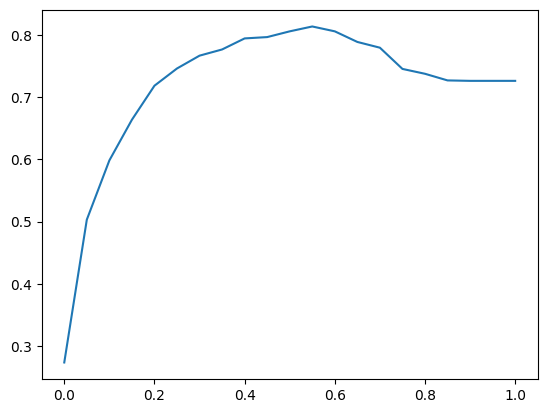

In [42]:
plt.plot(thresholds,scores)

In [60]:
from collections import Counter
Counter(y_pred >=1.0)
1-y_val.mean()

np.float64(0.7260468417317246)

## Confusion Table

In [61]:
actual_positive = (y_val == 1) 
actual_negative = (y_val == 0) 

In [ ]:
from sklearn.metrics import confusion_matrix
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()



array([[0.6515259 , 0.07452094],
       [0.11994322, 0.15400994]])

## Precision and Recall